In [3]:
import os
import sys
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

from colorama import Fore
c_ = Fore.CYAN
m_ = Fore.MAGENTA
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW
g_ = Fore.GREEN

In [4]:
no_ctl = True
scale = "rankgauss"
variance_threshould = 0.7
decompo = "PCA"
encoding = "dummy"

In [5]:
seed = 42
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Machine Learning/train_features.csv')
targets = pd.read_csv('/content/drive/MyDrive/Machine Learning/train_targets_scored.csv')
test = pd.read_csv('/content/drive/MyDrive/Machine Learning/test_features.csv')

In [7]:
if no_ctl:

    print(b_, "not_ctl")
    train = train[train["cp_type"] != "ctl_vehicle"]
    test = test[test["cp_type"] != "ctl_vehicle"]
    targets = targets.iloc[train.index]
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    targets.reset_index(drop = True, inplace = True)

 not_ctl


In [8]:
train.shape

(21948, 876)

In [9]:
test.shape

(3624, 876)

In [10]:
targets.shape

(21948, 207)

In [11]:
GENES = [col for col in train.columns if col.startswith("g-")]
CELLS = [col for col in train.columns if col.startswith("c-")]

In [12]:
data_all = pd.concat([train, test], ignore_index = True)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]
mask = (data_all[cols_numeric].var() >= variance_threshould).values
tmp = data_all[cols_numeric].loc[:, mask]
data_all = pd.concat([data_all[["sig_id", "cp_type", "cp_time", "cp_dose"]], tmp], axis = 1)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]

In [13]:
data_all.shape

(25572, 841)

In [14]:
data_all.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [15]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GaussRankScaler(BaseEstimator, TransformerMixin):
    

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
   
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
    
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
 
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [17]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def scale_norm(col):
    return (col - col.mean()) / col.std()

if scale == "boxcox":
    print(b_, "boxcox")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    trans = []
    for feat in cols_numeric:
        trans_var, lambda_var = stats.boxcox(data_all[feat].dropna() + 1)
        trans.append(scale_minmax(trans_var))
    data_all[cols_numeric] = np.asarray(trans).T
    
elif scale == "norm":
    print(b_, "norm")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_norm, axis = 0)
    
elif scale == "minmax":
    print(b_, "minmax")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    
elif scale == "rankgauss":
    print(b_, "Rank Gauss")
    scaler = GaussRankScaler()
    data_all[cols_numeric] = scaler.fit_transform(data_all[cols_numeric])
    
else:
    pass

 Rank Gauss


In [18]:
data_all.shape

(25572, 841)

In [20]:
GENES = [col for col in data_all.columns if col.startswith('g-')]
CELLS = [col for col in data_all.columns if col.startswith('c-')]

In [21]:
data_all[GENES].shape

(25572, 737)

In [22]:
data = data_all[GENES]

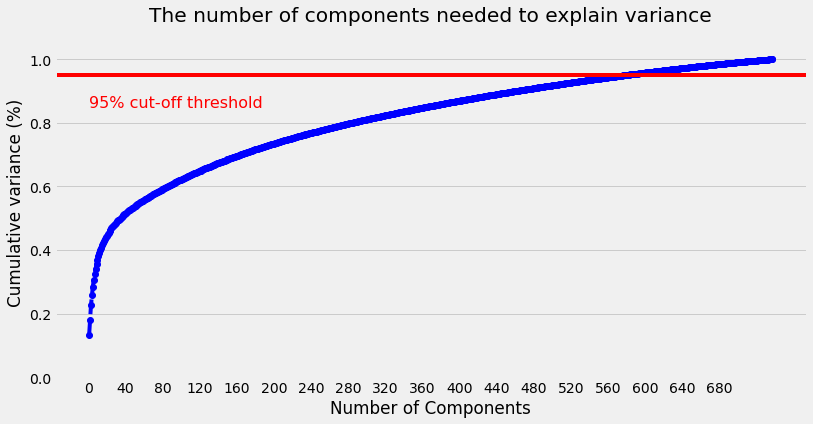

In [23]:
pca = PCA().fit(data)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 738, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 720, step=40)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [24]:
pca.explained_variance_ratio_.shape

(737,)

In [25]:
pca_df=pd.DataFrame(xi, columns=['Num_of_comp'])
pca_df['var']=y

In [26]:
pca_df[pca_df['var']>=0.95].head()

,Num_of_comp,var
579,580,0.950372
580,581,0.950750
581,582,0.951128
582,583,0.951505
583,584,0.951881


In [27]:
data = data_all[CELLS]

In [28]:
data.shape

(25572, 100)

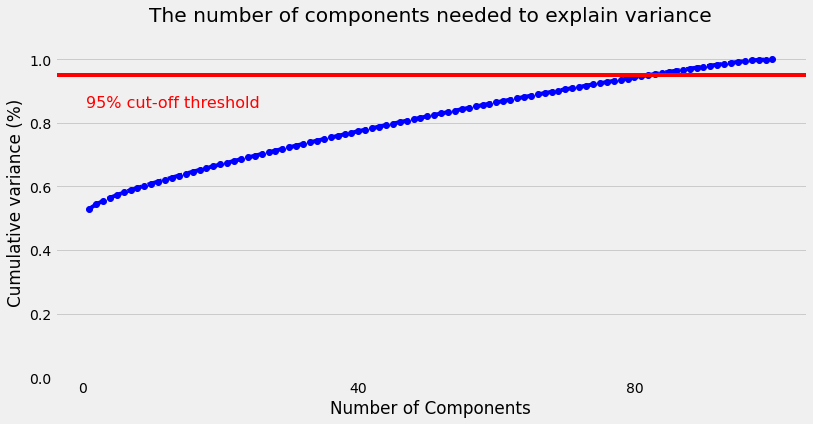

In [29]:
pca = PCA().fit(data)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1,101, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=40))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [30]:
pca_df=pd.DataFrame(xi, columns=['Num_of_comp'])
pca_df['var']=y

In [31]:
pca_df[pca_df['var']>=0.95].head() 

,Num_of_comp,var
82,83,0.953462
83,84,0.956954
84,85,0.960421
85,86,0.963809
86,87,0.967106


In [32]:
# PCA
ncompo_genes = 90
ncompo_cells = 20
if decompo == "PCA":
    print(b_, "PCA")
    GENES = [col for col in data_all.columns if col.startswith("g-")]
    CELLS = [col for col in data_all.columns if col.startswith("c-")]
    
    pca_genes = PCA(n_components = ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
    pca_cells = PCA(n_components = ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])
    
    pca_genes = pd.DataFrame(pca_genes, columns = [f"pca_g-{i}" for i in range(ncompo_genes)])
    pca_cells = pd.DataFrame(pca_cells, columns = [f"pca_c-{i}" for i in range(ncompo_cells)])
    data_all = pd.concat([data_all, pca_genes, pca_cells], axis = 1)
else:
    pass

 PCA


In [33]:
data_all.shape

(25572, 951)

In [34]:

if encoding == "lb":
    print(b_, "Label Encoding")
    for feat in ["cp_time", "cp_dose"]:
        data_all[feat] = LabelEncoder().fit_transform(data_all[feat])
elif encoding == "dummy":
    print(b_, "One-Hot")
    data_all = pd.get_dummies(data_all, columns = ["cp_time", "cp_dose"])

 One-Hot


In [35]:
data_all.shape

(25572, 954)

In [36]:
GENES = [col for col in data_all.columns if col.startswith("g-")]
CELLS = [col for col in data_all.columns if col.startswith("c-")]

for stats in tqdm.tqdm(["sum", "mean", "std", "kurt", "skew"]):
    data_all["g_" + stats] = getattr(data_all[GENES], stats)(axis = 1)
    data_all["c_" + stats] = getattr(data_all[CELLS], stats)(axis = 1)    
    data_all["gc_" + stats] = getattr(data_all[GENES + CELLS], stats)(axis = 1)

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


In [37]:
data_all.shape

(25572, 969)

In [38]:
def distributions(num, graphs, items, features, gorc):
    """
    Plot the distributions of gene expression or cell viability data
    """
    for i in range(0, num - 1, 7):
        if i >= 3:
            break
        idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    
        fig, axs = plt.subplots(1, 7, sharey = True)
        for k, item in enumerate(idxs):
            if item >= items:
                break
            graph = sns.distplot(data_all[features].values[:, item], ax = axs[k])
            graph.set_title(f"{gorc}-{item}")
            graphs.append(graph)

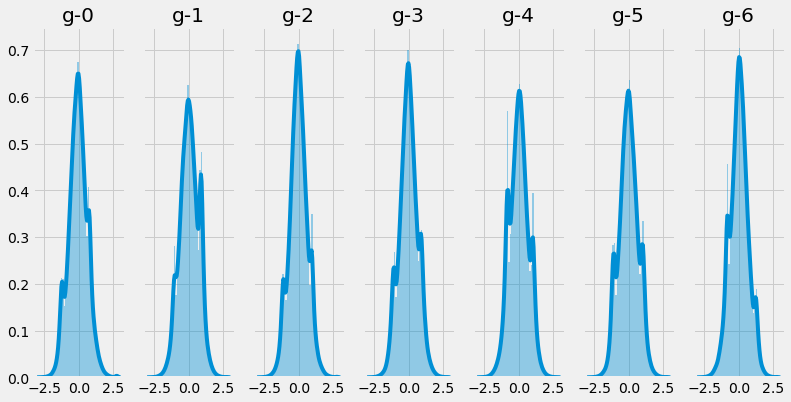

In [39]:
gnum = data_all[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 771, GENES, "g")

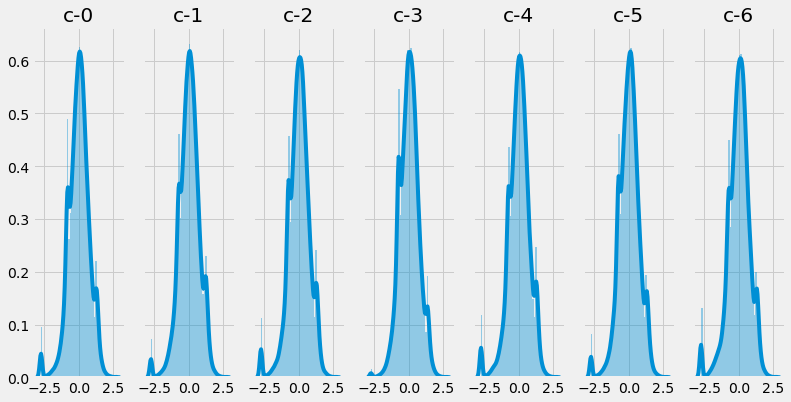

In [40]:
cnum = data_all[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

In [41]:

features_to_drop = ["sig_id", "cp_type"]
data_all.drop(features_to_drop, axis = 1, inplace = True)
try:
    targets.drop("sig_id", axis = 1, inplace = True)
except:
    pass
train_df = data_all[: train.shape[0]]
train_df.reset_index(drop = True, inplace = True)
test_df = data_all[train_df.shape[0]: ]
test_df.reset_index(drop = True, inplace = True)

In [42]:
print(f"{b_}train_df.shape: {r_}{train_df.shape}")
print(f"{b_}test_df.shape: {r_}{test_df.shape}")

train_df.shape: (21948, 967)
test_df.shape: (3624, 967)


In [43]:
X_test = test_df.values
print(f"{b_}X_test.shape: {r_}{X_test.shape}")

X_test.shape: (3624, 967)


In [44]:
MAX_EPOCH = 200
tabnet_params = dict(
    n_d = 32, 
    n_a = 32, 
    n_steps = 1, 
    gamma = 1.5, 
    lambda_sparse = 0,
    optimizer_fn = optim.Adam, 
    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),  
    scheduler_fn = ReduceLROnPlateau, 
    seed = seed,
    verbose = 10
)

In [45]:
class LogitsLogLoss(Metric):
    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

In [46]:
scores_auc_all = []
test_cv_preds = []

NB_SPLITS = 10 # 7
mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = 0, shuffle = True)

oof_preds = []
oof_targets = []
scores = []
scores_auc = []
for fold_nb, (train_idx, val_idx) in enumerate(mskf.split(train_df, targets)):
    print(b_,"FOLDS: ", r_, fold_nb + 1)
    print(g_, '*' * 60, c_)
    
    X_train, y_train = train_df.values[train_idx, :], targets.values[train_idx, :]
    X_val, y_val = train_df.values[val_idx, :], targets.values[val_idx, :]

    model = TabNetRegressor(**tabnet_params)

    model.fit(
        X_train = X_train,
        y_train = y_train,
        eval_set = [(X_val, y_val)],
        eval_name = ["val"],
        eval_metric = ["logits_ll"],
        max_epochs = MAX_EPOCH,
        patience = 20,
        batch_size = 1024,
        virtual_batch_size = 32,
        num_workers = 1,
        drop_last = False,

        loss_fn = F.binary_cross_entropy_with_logits
    )
    print(y_, '-' * 60)
 
    preds_val = model.predict(X_val)

    preds = 1 / (1 + np.exp(-preds_val))
    score = np.min(model.history["val_logits_ll"])
    
    oof_preds.append(preds_val)
    oof_targets.append(y_val)
    scores.append(score)

    preds_test = model.predict(X_test)
    test_cv_preds.append(1 / (1 + np.exp(-preds_test)))

oof_preds_all = np.concatenate(oof_preds)
oof_targets_all = np.concatenate(oof_targets)
test_preds_all = np.stack(test_cv_preds)

 FOLDS:   1
 ************************************************************ 
Device used : cuda
epoch 0  | loss: 0.31854 | val_logits_ll: 0.03    |  0:00:02s
epoch 10 | loss: 0.01892 | val_logits_ll: 0.01863 |  0:00:25s
epoch 20 | loss: 0.01734 | val_logits_ll: 0.0195  |  0:00:46s
epoch 30 | loss: 0.01696 | val_logits_ll: 0.01742 |  0:01:07s
epoch 40 | loss: 0.01669 | val_logits_ll: 0.017   |  0:01:29s
epoch 50 | loss: 0.01653 | val_logits_ll: 0.0168  |  0:01:50s
epoch 60 | loss: 0.01627 | val_logits_ll: 0.01673 |  0:02:11s
epoch 70 | loss: 0.01603 | val_logits_ll: 0.01659 |  0:02:33s
epoch 80 | loss: 0.0158  | val_logits_ll: 0.01694 |  0:02:54s
epoch 90 | loss: 0.01567 | val_logits_ll: 0.01657 |  0:03:15s
epoch 100| loss: 0.01541 | val_logits_ll: 0.01671 |  0:03:38s
epoch 110| loss: 0.01533 | val_logits_ll: 0.01649 |  0:03:59s
epoch 120| loss: 0.01519 | val_logits_ll: 0.01692 |  0:04:22s

Early stopping occured at epoch 128 with best_epoch = 108 and best_val_logits_ll = 0.01648
Best wei

In [47]:
aucs = []
for task_id in range(oof_preds_all.shape[1]):
    aucs.append(roc_auc_score(y_true = oof_targets_all[:, task_id],
                              y_score = oof_preds_all[:, task_id]
                             ))
print(f"{b_}Overall AUC: {r_}{np.mean(aucs)}")
print(f"{b_}Average CV: {r_}{np.mean(scores)}")

Overall AUC: 0.7540415208470693
Average CV: 0.016474699774517147


In [48]:
all_feat = [col for col in submission.columns if col not in ["sig_id"]]
test = pd.read_csv('../input/lish-moa/test_features.csv')
sig_id = test[test["cp_type"] != "ctl_vehicle"].sig_id.reset_index(drop = True)
tmp = pd.DataFrame(test_preds_all.mean(axis = 0), columns = all_feat)
tmp["sig_id"] = sig_id

submission = pd.merge(test[["sig_id"]], tmp, on = "sig_id", how = "left")
submission.fillna(0, inplace = True)
submission.to_csv("Team_GOAT_submission.csv", index = None)
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001107,0.001247,0.002031,0.014206,0.020951,0.004910,0.002159,0.006485,0.000261,...,0.000796,0.001256,0.003873,0.001201,0.000722,0.000634,0.000658,0.001775,0.003156,0.001631
1,id_001897cda,0.000638,0.001141,0.001673,0.002610,0.002116,0.002699,0.002175,0.011165,0.001681,...,0.000694,0.000971,0.002884,0.000288,0.004568,0.000647,0.005366,0.001207,0.012786,0.002549
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001080,0.000999,0.001865,0.010206,0.020218,0.003979,0.003158,0.004689,0.000264,...,0.000624,0.001706,0.002632,0.012790,0.003810,0.000606,0.001172,0.001963,0.000339,0.001788
4,id_0027f1083,0.001500,0.001412,0.001547,0.012637,0.021167,0.005112,0.003371,0.003894,0.000552,...,0.000664,0.000686,0.003274,0.000874,0.001120,0.000693,0.000645,0.001851,0.000609,0.001986
